# Invest $10,000
## Which Stock Will YOU Choose?

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

while True:
    code = input("Enter the 4 character code for your stock of choice. Or just choose AAPL if lazy > ").upper()
    startDate = input("Start Date? (YYYY-MM-DD)> ")
    endDate = input("End Date? (YYYY-MM-DD)> ")

    if startDate > endDate:
        print("Start Date must be before End Date!")
        continue

    startDate = datetime.strptime(startDate, "%Y-%m-%d")#subtract 50 days to adjust for sma delay
    startDate = startDate - timedelta(days=50)
    startDate = startDate.strftime("%Y-%m-%d")
    

    stock = yf.download(code, start=startDate, end=endDate)
    print(stock.columns)

    # Download stock data
    stock = yf.download(code, start=startDate, end=endDate)

    # Flatten MultiIndex: Use only the 'Price' level
    if isinstance(stock.columns, pd.MultiIndex):
        stock.columns = stock.columns.droplevel(1)

    # Ensure 'Close' column exists
    if 'Close' not in stock.columns:
        print("Error: 'Close' column is missing. Check the ticker symbol.")
        print(stock.head())
        exit()

    print(stock.head(2))

    # Calculate the SMAs
    stock["SMA_10"] = stock["Close"].rolling(window=10).mean()
    stock["SMA_20"] = stock["Close"].rolling(window=20).mean()



    if stock.empty:
        print(f"No data found for '{code}'. Check the stock code and date range.")
        continue

    break


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

MultiIndex([( 'Close', 'AAPL'),
            (  'High', 'AAPL'),
            (   'Low', 'AAPL'),
            (  'Open', 'AAPL'),
            ('Volume', 'AAPL')],
           names=['Price', 'Ticker'])
Price            Close        High         Low        Open    Volume
Date                                                                
2022-11-14  146.575775  148.552789  145.735538  147.257847  73374100
2022-11-15  148.315552  151.824754  146.852566  150.470504  89868300


...
This strategy uses 10 and 20 Day Simple Moving Averages.
When SMA_10 (blue) overtakes SMA_20 (red), you buy $10,000 worth
And when SMA_10 gets overtaken by SMA_20, you sell all for cash
10000.0 = 142.8292999267578 * 0
10000.0 = 143.79808044433594 * 0
10000.0 = 141.5640411376953 * 0
10000.0 = 134.93113708496094 * 0
10000.0 = 132.9640350341797 * 0
10000.0 = 130.84861755371094 * 0
10000.0 = 130.77943420410156 * 0
10000.0 = 133.8932342529297 * 0
10000.0 = 130.71022033691406 * 0
10000.0 = 130.34449768066406 * 0
10000.0 = 128.53553771972656 * 0
10000.0 = 124.59138488769531 * 0
10000.0 = 128.12037658691406 * 0
10000.0 = 128.43667602539062 * 0
10000.0 = 123.63252258300781 * 0
10000.0 = 124.90772247314453 * 0
10000.0 = 123.58309936523438 * 0
10000.0 = 128.1302490234375 * 0
10000.0 = 128.6541290283203 * 0
10000.0 = 129.22747802734375 * 0
10000.0 = 131.95578002929688 * 0
10000.0 = 131.87669372558594 * 0
10000.0 = 133.2111358642578 * 0
10000.0 = 134.3776092529297 * 0
10000.0 = 133.655975341796

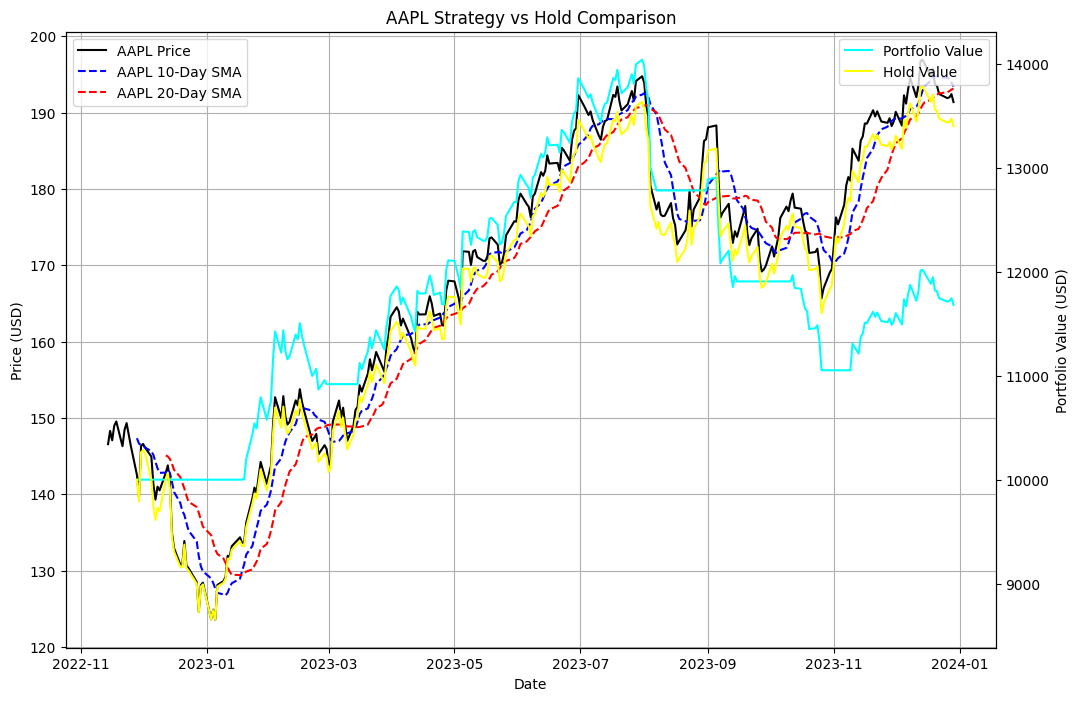

In [ ]:

#print(stock.head(2))
print("...")
print("This strategy uses 10 and 20 Day Simple Moving Averages.")
print("When SMA_10 (blue) overtakes SMA_20 (red), you buy $10,000 worth")
print("And when SMA_10 gets overtaken by SMA_20, you sell all for cash")

stock["SMA_10"] = stock["Close"].rolling(window=10).mean()
stock["SMA_20"] = stock["Close"].rolling(window=20).mean()

currentCash = 10000
currentStocksBought = 0
currentValue = 10000
buys = 0
sells = 0

holdCash = 10000
holdStocksBought = 0
holdValue = 0
holding = False

# # Initial setup for hold strategy
# initialPrice = stock.iloc[0]["Close"]
# holdStocksBought = holdCash / initialPrice
# holdCash = 0
# stock.loc[stock.index[0], "Hold_Value"] = holdStocksBought * initialPrice

for date, row in stock.iterrows():
  if pd.isna(row["SMA_10"]) or pd.isna(row["SMA_20"]) or pd.isna(row["Close"]):
    continue

  currentPrice = row["Close"]
  
  # passive strategy
  holdValue = holdStocksBought * currentPrice
  stock.loc[date, "Hold_Value"] = holdValue
  
  # Trading strategy
  sma10 = row["SMA_10"]
  sma20 = row["SMA_20"]

  if holding == False:
    holdStocksBought = holdCash / currentPrice
    holdCash = 0
    stock.loc[date, "Hold_Value"] = holdStocksBought * currentPrice
    holding = True

  if sma10 > sma20:
    if currentCash > 0:
      currentStocksBought = currentCash / currentPrice
      currentCash = 0
      buys += 1
  else:
    if currentStocksBought > 0:
      currentCash = currentStocksBought * currentPrice
      currentStocksBought = 0
      sells += 1

  assetsValue = currentStocksBought * currentPrice
  currentValue = assetsValue + currentCash
  stock.loc[date, "Portfolio_Value"] = currentValue

  print(str(currentValue) + " = " + str(currentPrice) + " * " + str(currentStocksBought))

# Ensure correct data type
stock["Portfolio_Value"] = stock["Portfolio_Value"].astype(float)
stock["Hold_Value"] = stock["Hold_Value"].astype(float)

print(f"Final portfolio value: ${currentValue:.2f}")
print(f"Hypothetical hold value: ${holdValue:.2f}")

fig, ax1 = plt.subplots(figsize=(12, 8))  # Create the figure and first y-axis

# Plot stock price and SMAs on the first y-axis
ax1.plot(stock.index, stock["Close"], label=code + " Price", color="black")
ax1.plot(stock.index, stock["SMA_10"], label=code + " 10-Day SMA", linestyle="--", color="blue")
ax1.plot(stock.index, stock["SMA_20"], label=code + " 20-Day SMA", linestyle="--", color="red")
ax1.set_xlabel("Date")
ax1.set_ylabel("Price (USD)")
ax1.legend(loc="upper left") # legend is the label thing
ax1.grid(True)

# Create a second y-axis and plot the portfolio and hold values
ax2 = ax1.twinx()  
ax2.plot(stock.index, stock["Portfolio_Value"], label="Portfolio Value", color="cyan")
ax2.plot(stock.index, stock["Hold_Value"], label="Hold Value", color="yellow")
ax2.set_ylabel("Portfolio Value (USD)")
ax2.legend(loc="upper right")


plt.title(code + " Strategy vs Hold Comparison")
plt.show()